In [1]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from matplotlib import pyplot as plt

## Creating Target Variable

In [3]:
df = pd.read_csv('train.csv')
targets = list(df.columns[2:])
df_targets = df[targets].copy()

toxic_rows = df_targets.sum(axis=1)
is_toxic = (toxic_rows > 0)

# Creating target variable

df_targets['toxic_comment'] = is_toxic
print(df_targets.head(10))

# Encoding the target variable

df_targets['toxic_comment'] = df_targets['toxic_comment'].apply(lambda x: 0 if x==False else 1)


print(df_targets.shape)

print(df_targets.head(10))


   malignant  highly_malignant  rude  threat  abuse  loathe  toxic_comment
0          0                 0     0       0      0       0          False
1          0                 0     0       0      0       0          False
2          0                 0     0       0      0       0          False
3          0                 0     0       0      0       0          False
4          0                 0     0       0      0       0          False
5          0                 0     0       0      0       0          False
6          1                 1     1       0      1       0           True
7          0                 0     0       0      0       0          False
8          0                 0     0       0      0       0          False
9          0                 0     0       0      0       0          False
(159571, 7)
   malignant  highly_malignant  rude  threat  abuse  loathe  toxic_comment
0          0                 0     0       0      0       0              0
1          0 

## Bag of Words and Cleaning the StopWords

We will convert processed text to numeric feature vectors to feed it to machine learning algorithms.
Bag of Words takes a document from corpus and converts into a numeric vector by mapping each document word to a feature vector.

In [4]:
# Specifying input data and target variable for the algorithm

# input data
x = df['comment_text']

# target variable
y = df_targets['toxic_comment']

# Split into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=42)

# Vectorize text comments to numbers
vec = CountVectorizer(stop_words='english', max_features=2000)

x_train = vec.fit_transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()

# MODEL IMPLEMENTATION
## NAIVE BAYES ALGORITHM

After splitting and vectorizing text comments into numbers, we will generate a naive bayes model on the training set and perform prediction on test set features.

In [5]:
classifier = MultinomialNB()
classifier.fit(x_train, y_train)

y_pred  =  classifier.predict(x_test)

Checking the accuracy of the model after it has been created by comparing real and anticipated values. This model is 94 % accurate.

In [6]:
# Calculate the accuracy score to see the performance of the model

ac = accuracy_score(y_test,y_pred)

print('Accuracy score of the model:', ac)

Accuracy score of the model: 0.9422204396761337


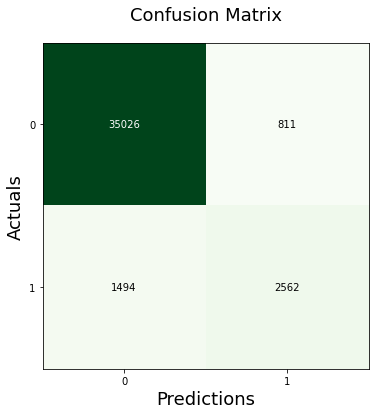

In [7]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

We can try random text examples and see how our model predicts if the given text is toxic or clean.

In [8]:
result = classifier.predict(vec.transform(['I will kill you']))
print(result)

[1]


In [9]:
result = classifier.predict(vec.transform(['Would you meet me on Tuesday evening?']))
print(result)

[0]


# PROTOTYPING AND CROSS VALIDATION

I decided to build 4 different models to see their accurary. 
Naive Bayes, KNN, Decision Tree and Random Forest.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

models = []

models.append(('NB', MultinomialNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT',  DecisionTreeClassifier()))
models.append(('RF',  RandomForestClassifier(n_estimators=100)))

In [11]:
# Train/Test split
X_train_cross, X_test_cross, y_train_cross, y_test_cross = train_test_split(x, y, stratify = df_targets.toxic_comment, random_state=0)

# Vectorize text comments to numbers
vec = CountVectorizer(stop_words='english', max_features=10)

X_train_cross = vec.fit_transform(X_train_cross).toarray()
X_test_cross = vec.transform(X_test_cross).toarray()

In [12]:
names = []
scores = []

for name, model in models:
    model.fit(X_train_cross, y_train_cross)
    y_pred_cross = model.predict(X_test_cross)
    scores.append(accuracy_score(y_test_cross, y_pred_cross))
    names.append(name)

tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name     Score
0   NB  0.889053
1  KNN  0.894342
2   DT  0.893014
3   RF  0.897025


Random Forest gave me the best results no matter With or without cross validation 

In [13]:
# Cross validation starts here

strat_k_fold = StratifiedKFold(n_splits=10)

names = []
scores = []

# Vectorize text comments to numbers
vec = CountVectorizer(stop_words='english', max_features=10)

x_vectorized = vec.fit_transform(x).toarray()

for name, model in models:
    
    score = cross_val_score(model, x_vectorized, y, cv=strat_k_fold, scoring='accuracy').mean()
    names.append(name)
    scores.append(score)

kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

  Name     Score
0   NB  0.890130
1  KNN  0.892650
2   DT  0.893796
3   RF  0.897281


# MODELLING
## RANDOM FOREST
By doing trial and error I concluded that using 10 trees is reasnable.
Therefore I tuned my hyperparameter n_estimators to 20.

In [14]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0, n_estimators=50)

# fit the model
rfc.fit(x_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(x_test)

# Check accuracy score 
from sklearn.metrics import accuracy_score

print('Model accuracy score with 50 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 50 decision-trees : 0.9462


In [15]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rfc.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [16]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0, n_estimators=10)

# fit the model
rfc.fit(x_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(x_test)

# Check accuracy score 
from sklearn.metrics import accuracy_score

print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.9433


In [17]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rfc.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [ ]:
# Confusion matrix for 10 trees

cm = confusion_matrix(y_test, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [18]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0, n_estimators=5)

# fit the model
rfc.fit(x_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(x_test)

# Check accuracy score 
from sklearn.metrics import accuracy_score

print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.9388
